# RHF 偶极矩相关

In [1]:
from pyscf import gto, scf
import numpy as np
from matplotlib import pyplot as plt

np.set_printoptions(precision=5, linewidth=150, suppress=True)

我们使用的分子是 6-31G 的氨分子，其分子方向是伞形向上，因此偶极矩方向是 $z$ 轴向下的。

In [2]:
mol = gto.Mole()
mol.atom = """
N        0.000000    0.000000    0.059497
H        0.000000    0.971370   -0.138827
H        0.841231   -0.485685   -0.138827
H       -0.841231   -0.485685   -0.138827
"""
mol.basis = "6-31G"
mol.verbose = 0
mol.build()

我们先对没有外加电场的分子作计算并保存到 `mf` 实例中。

In [3]:
mf = scf.RHF(mol).run()

其解析偶极矩可以通过下述代码求得：

$$
d_r = - D_{\mu \nu} \langle \mu | r | \nu \rangle
$$

In [4]:
dip_anal = - (mf.make_rdm1() * mol.intor("int1e_r")).sum(axis=(-1, -2))
dip_anal

array([-0.     , -0.     , -0.54556])

## 单点能随外加电场的函数

`zfield_to_eng` 对应 $E^\mathsf{HF} (F_z)$ 的函数：

In [5]:
def zfield_to_eng(intense, direct=2):
    mf = scf.RHF(mol)
    mf.get_hcore = lambda mol: mol.intor("int1e_kin") + mol.intor("int1e_nuc") - intense * mol.intor("int1e_r")[direct]
    return mf.run().e_tot

In [6]:
intense_list = np.linspace(-0.3, 0.3, 61)
intense_list

array([-0.3 , -0.29, -0.28, -0.27, -0.26, -0.25, -0.24, -0.23, -0.22, -0.21, -0.2 , -0.19, -0.18, -0.17, -0.16, -0.15, -0.14, -0.13, -0.12, -0.11,
       -0.1 , -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01,  0.  ,  0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,  0.08,  0.09,
        0.1 ,  0.11,  0.12,  0.13,  0.14,  0.15,  0.16,  0.17,  0.18,  0.19,  0.2 ,  0.21,  0.22,  0.23,  0.24,  0.25,  0.26,  0.27,  0.28,  0.29,
        0.3 ])

In [7]:
eng_list = [zfield_to_eng(intense) for intense in intense_list]
eng_list = np.array(eng_list)

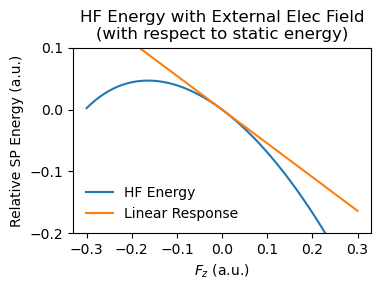

In [10]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(intense_list, eng_list - mf.e_tot, label="HF Energy")
ax.plot([-0.3, 0.3], [-0.3 * dip_anal[2], 0.3 * dip_anal[2]], label="Linear Response")
ax.set_ylim(-0.2, 0.1)
ax.legend(framealpha=0)
ax.set_title("HF Energy with External Elec Field\n(with respect to static energy)")
ax.set_xlabel("$F_z$ (a.u.)")
ax.set_ylabel("Relative SP Energy (a.u.)")
fig.tight_layout()
fig.savefig("NumDipole_z.png", dpi=300, transparent=True)
fig.savefig("NumDipole_z.pdf", dpi=300, transparent=True)

In [9]:
engx_list = [zfield_to_eng(intense, 0) for intense in intense_list]
engx_list = np.array(engx_list)

<IPython.core.display.Javascript object>


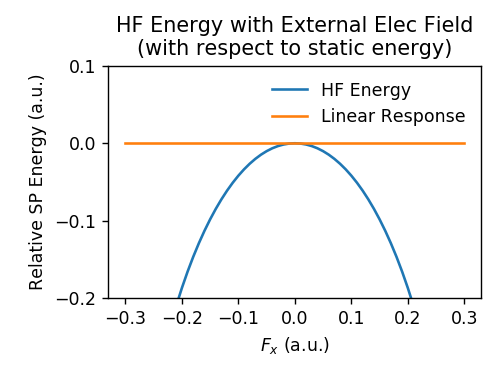

In [10]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(intense_list, engx_list - mf.e_tot, label="HF Energy")
ax.plot([-0.3, 0.3], [-0.3 * dip_anal[0], 0.3 * dip_anal[0]], label="Linear Response")
ax.set_ylim(-0.2, 0.1)
ax.legend(framealpha=0)
ax.set_title("HF Energy with External Elec Field\n(with respect to static energy)")
ax.set_xlabel("$F_x$ (a.u.)")
ax.set_ylabel("Relative SP Energy (a.u.)")
fig.tight_layout()
fig.savefig("NumDipole_2.png", dpi=300, transparent=True)

In [11]:
engy_list = [zfield_to_eng(intense, 1) for intense in intense_list]
engy_list = np.array(engy_list)

<IPython.core.display.Javascript object>


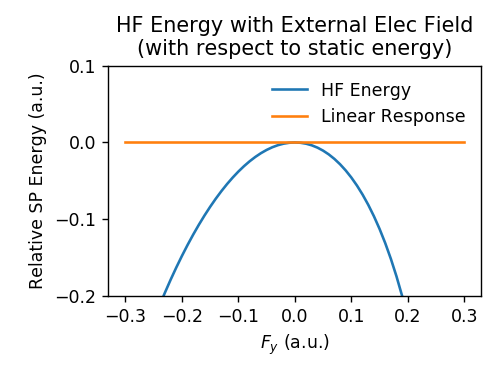

In [12]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(intense_list, engy_list - mf.e_tot, label="HF Energy")
ax.plot([-0.3, 0.3], [-0.3 * dip_anal[1], 0.3 * dip_anal[1]], label="Linear Response")
ax.set_ylim(-0.2, 0.1)
ax.legend(framealpha=0)
ax.set_title("HF Energy with External Elec Field\n(with respect to static energy)")
ax.set_xlabel("$F_y$ (a.u.)")
ax.set_ylabel("Relative SP Energy (a.u.)")
fig.tight_layout()
fig.savefig("NumDipole_3.png", dpi=300, transparent=True)

## 三点数值差分的偶极矩

`numerical_dipole` 对应的是下述三点差分：

$$
d_z (F_z) = \frac{E^\mathsf{HF} (F_z) - E^\mathsf{HF} (- F_z)}{2 F_z}
$$

应当满足下述极限 (理想情况)：

$$
\lim_{F_z \rightarrow 0} = \frac{\partial E^\mathsf{HF} (F_z)}{\partial F_z}
$$

但由于机器精度，这种极限是无法达到的，必然存在数值误差。

In [13]:
def numerical_dipole(interval):
    return (zfield_to_eng(interval) - zfield_to_eng(-interval)) / (2 * interval)

In [14]:
interval_list = np.logspace(-16, 0, 81)
np.log10(interval_list)

array([-16. , -15.8, -15.6, -15.4, -15.2, -15. , -14.8, -14.6, -14.4, -14.2, -14. , -13.8, -13.6, -13.4, -13.2, -13. , -12.8, -12.6, -12.4, -12.2,
       -12. , -11.8, -11.6, -11.4, -11.2, -11. , -10.8, -10.6, -10.4, -10.2, -10. ,  -9.8,  -9.6,  -9.4,  -9.2,  -9. ,  -8.8,  -8.6,  -8.4,  -8.2,
        -8. ,  -7.8,  -7.6,  -7.4,  -7.2,  -7. ,  -6.8,  -6.6,  -6.4,  -6.2,  -6. ,  -5.8,  -5.6,  -5.4,  -5.2,  -5. ,  -4.8,  -4.6,  -4.4,  -4.2,
        -4. ,  -3.8,  -3.6,  -3.4,  -3.2,  -3. ,  -2.8,  -2.6,  -2.4,  -2.2,  -2. ,  -1.8,  -1.6,  -1.4,  -1.2,  -1. ,  -0.8,  -0.6,  -0.4,  -0.2,
         0. ])

In [15]:
numdip_list = [numerical_dipole(interval) for interval in interval_list]
numdip_list = np.array(numdip_list)

<IPython.core.display.Javascript object>


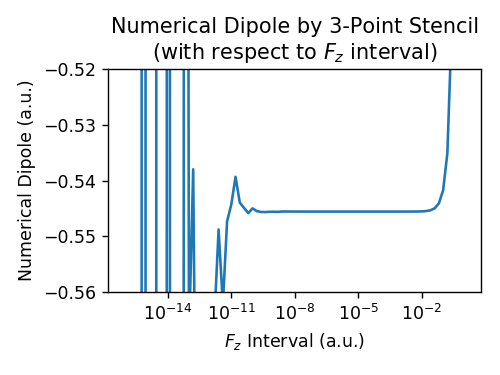

In [16]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(interval_list, numdip_list)
ax.set_title("Numerical Dipole by 3-Point Stencil\n(with respect to $F_z$ interval)")
ax.set_xscale("log")
ax.set_ylim(-0.56, -0.52)
ax.set_xlabel("$F_z$ Interval (a.u.)")
ax.set_ylabel("Numerical Dipole (a.u.)")
fig.tight_layout()
fig.savefig("NumDipole_4.png", dpi=300, transparent=True)